In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from pandas import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from pandas import Series

from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.model_selection import train_test_split

In [2]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [3]:
# dataset united kingdom
#case = pd.read_csv('UK/case.csv')
#mobility = pd.read_csv('UK/mobility.csv')
#case.set_index('date', inplace=True)
#mobility.set_index('date', inplace=True)

# dataset indonesia (jakarta)
case = pd.read_csv('data/new/case_maret_july.csv')
mobility = pd.read_csv('data/new/mobility_maret_july.csv')
weather = pd.read_csv('data/new/weather_maret_july.csv')
case.set_index('date', inplace=True)
#weather.set_index('date', inplace=True)
mobility.set_index('date', inplace=True)

In [4]:
new_weather = weather.interpolate(method='spline', order=2)
new_weather.head()

new_weather.set_index('date', inplace=True)

In [5]:
data = pd.concat([case, new_weather, mobility], axis=1)
data.head()

,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
date,,,,,,,,,,,
2020-03-18,38,86.0,27.6,29.0,25.800000,-22,-3,-28,-32,-19,11
2020-03-19,50,83.0,28.1,31.4,25.800000,-28,-12,-33,-38,-21,12
2020-03-20,14,82.0,27.4,31.2,25.200000,-30,-11,-32,-42,-23,15
2020-03-21,44,81.0,28.1,32.4,26.521978,-35,-5,-38,-40,-10,11
2020-03-22,36,84.0,27.2,31.2,25.000000,-49,-22,-59,-49,-12,14


In [6]:
cointegration_test(data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
case   ::  389.61    > 263.2603  =>   True
rh     ::  291.11    > 219.4051  =>   True
avt    ::  204.11    > 179.5199  =>   True
mxt    ::  143.32    > 143.6691  =>   False
mnt    ::  94.52     > 111.7797  =>   False
retail_recreation ::  56.28     > 83.9383   =>   False
grocery_pahrmacy ::  34.06     > 60.0627   =>   False
parks  ::  20.25     > 40.1749   =>   False
transit_station ::  9.11      > 24.2761   =>   False
workplace ::  1.93      > 12.3212   =>   False
residential ::  0.02      > 4.1296    =>   False


In [7]:
model = VARMAX(data, order=(3,1))
model_fit = model.fit(disp=False)
print(model_fit.summary())

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                                                                    Statespace Model Results                                                                                    
Dep. Variable:     ['case', 'rh', 'avt', 'mxt', 'mnt', 'retail_recreation', 'grocery_pahrmacy', 'parks', 'transit_station', 'workplace', 'residential']   No. Observations:                  423
Model:                                                                                                                                       VARMA(3,1)   Log Likelihood              -11445.487
                                                                                                                                            + intercept   AIC                          24012.974
Date:                                                                                                                                  Sun, 22 Aug 2021   BIC                          26283.550
Time:                              

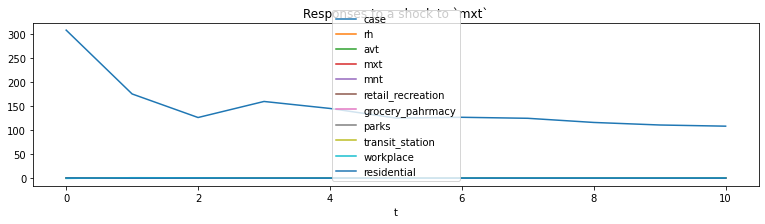

In [8]:
ax = model_fit.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses to a shock to `mxt`');

In [9]:
yhat = model_fit.forecast()
print(yhat)

                  case        rh        avt        mxt        mnt  \
2021-05-15  526.786655  73.16289  30.025408  34.075297  26.429013   

            retail_recreation  grocery_pahrmacy    parks  transit_station  \
2021-05-15         -20.112632          4.434213 -16.1817       -42.341369   

            workplace  residential  
2021-05-15 -61.291837    13.325379  


In [10]:
hasil = model_fit.forecast(17)
list_hasil = hasil['case'].tolist()

In [11]:
evalu = pd.read_csv('data/new/evaluation.csv')
list_eval = evalu['case'].tolist()

In [12]:
test_list = [int(i) for i in list_hasil]
test_list

[526,
 650,
 566,
 412,
 359,
 378,
 343,
 337,
 350,
 344,
 336,
 338,
 343,
 346,
 351,
 357,
 363]

In [13]:
rms = mean_squared_error(list_eval, test_list, squared=False)
rms

431.8565938445989

In [14]:
mse = mean_squared_error(list_eval, test_list)
mse

186500.11764705883

In [15]:
mae = mean_absolute_error(list_eval, test_list)
mae

391.05882352941177